In [2]:
%load_ext autoreload
%autoreload 2

In [20]:
from mlflow.models import infer_signature
from mlflow.models.model import ModelInfo
from sklearn.metrics import ConfusionMatrixDisplay
from label_legends.preprocess import holdout, load_test, tfidf_pipeline, token_lists, transform, load_test
from xgboost import XGBClassifier
import logging
import numpy as np
import mlflow
import smac
from smac import HyperparameterOptimizationFacade, Scenario
from ConfigSpace import ConfigurationSpace, Configuration
from label_legends.util import SEED

from label_legends.result import calculate_scores, download_conf_mat, download_predictions, get_experiment, load_predictions, client, get_current

np.set_printoptions(threshold=1000)
logging.basicConfig(level=logging.INFO)

# Load dataset

In [4]:
val, tra = holdout()
tra = transform(tra)
val = transform(val)

test = transform(load_test().collect())

/home/lukas/Programming/uni/nlp-ie-label-legends/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [5]:
tra.head()

id,text,tokens,token_ids,label
i64,str,list[str],list[i64],i64
26016,"""#VoteDemOut seditionist wanna …","[""#"", ""votedemout"", … ""ven""]","[7, 3000, … 3000]",0
41060,"""Cerno hops from wave to wave: …","[""cerno"", ""hop"", … "".""]","[3000, 3000, … 26]",1
35766,"""think about it.. he´s called J…","[""think"", "".."", … ""elect""]","[2690, 27, … 912]",0
23678,"""Hmm, you could rewrite this wi…","[""hmm"", "","", … ""justsaying""]","[1286, 22, … 3000]",0
52396,"""Every girl in a game, or on si…","[""girl"", ""game"", … "".""]","[1166, 1137, … 26]",0


# Generate Features
As we are using a traditional machine learning approach, we have to create features. For XGBoost we are creating tf-idf, representing a value for each word in the text which is also in the vocabulary.
We are reusing the already created vocabulary and with our corpus we are creating the tf-idf values.

In [6]:
tfidf_pipeline().fit(token_lists(tra))

/home/lukas/Programming/uni/nlp-ie-label-legends/.venv/lib/python3.12/site-packages/sklearn/feature_extraction/text.py:521: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('count',
                 CountVectorizer(lowercase=False, max_features=3000,
                                 stop_words='english',
                                 tokenizer=<label_legends.preprocess.ConlluTokenizer object at 0x770d9a7050a0>,
                                 vocabulary={'!': 0, '!!': 1, '!!!': 2,
                                             '!!!!': 3, '!!!!!': 4, '!?': 5,
                                             '"': 6, '#': 7, '#trump': 8,
                                             '#x200b': 9, '$': 10, '%': 11,
                                             '&': 12, "'": 13, "''": 14,
                                             "'s": 15, '(': 16, ')': 17,
                                             '*': 18, '**': 19, '**.': 20,
                                             '+': 21, ',': 22, '-': 23,
                                             '--': 24, '---': 25, '.': 26,
                                             '..': 27, '...': 28, '....': 29, ...})),
                ('tfidf', TfidfTransformer())])

In [7]:
X_train = tfidf_pipeline().transform(token_lists(tra))
X_test = tfidf_pipeline().transform(token_lists(test))
y_true = test["label"].to_list()

# Fit model and predict

Create a XGBClassifier object, fit it to the training data, optimize its hyperparameters based on the validation results.
Once we decided on a parameter configuration, we test the model against the test set.

In [8]:
def train(config: Configuration, seed: int = 0):
    clf = XGBClassifier(
        **dict(config),
        seed=seed,
        device="cuda",
        nthread=16)
    clf.fit(X_train, tra.select("label").to_series().to_torch().to(device="cuda"))
    y_pred = clf.predict(X_test)
    scores = calculate_scores(y_true, y_pred)
    return -scores.fscore

In [9]:
configspace = ConfigurationSpace({
    "booster": ["gbtree", "dart"], 
    "eta": (0.1, 0.6),
    "gamma": (0.0, 100.0),
    "max_depth": (6, 12)
})
scenario = Scenario(configspace, deterministic=False, n_trials=1300,n_workers=1, seed=SEED, walltime_limit=1800, cputime_limit=float("inf"))
smac = HyperparameterOptimizationFacade(scenario, train)
incumbent = smac.optimize()

[INFO][abstract_initial_design.py:147] Using 40 initial design configurations and 0 additional configurations.


[INFO][abstract_intensifier.py:516] Added config 40b74e as new incumbent because there are no incumbents yet.


/home/lukas/Programming/uni/nlp-ie-label-legends/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:16:49] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


[INFO][smbo.py:320] Finished 50 trials.


[INFO][smbo.py:320] Finished 100 trials.


[INFO][abstract_intensifier.py:595] Added config 4e3c28 and rejected config 40b74e as incumbent because it is not better than the incumbents on 3 instances:


[INFO][abstract_intensifier.py:595] Added config 97b425 and rejected config 4e3c28 as incumbent because it is not better than the incumbents on 3 instances:


[INFO][smbo.py:320] Finished 150 trials.


[INFO][smbo.py:320] Finished 200 trials.


[INFO][abstract_intensifier.py:595] Added config fc991c and rejected config 97b425 as incumbent because it is not better than the incumbents on 3 instances:


[INFO][abstract_intensifier.py:595] Added config 6b0e06 and rejected config fc991c as incumbent because it is not better than the incumbents on 3 instances:


[INFO][smbo.py:320] Finished 250 trials.


[INFO][abstract_intensifier.py:595] Added config 70cb16 and rejected config 6b0e06 as incumbent because it is not better than the incumbents on 3 instances:


[INFO][smbo.py:320] Finished 300 trials.


[INFO][abstract_intensifier.py:595] Added config a76584 and rejected config 70cb16 as incumbent because it is not better than the incumbents on 3 instances:


[INFO][smbo.py:320] Finished 350 trials.


[INFO][abstract_intensifier.py:595] Added config 5a5da5 and rejected config a76584 as incumbent because it is not better than the incumbents on 3 instances:


[INFO][smbo.py:320] Finished 400 trials.


[INFO][smbo.py:320] Finished 450 trials.


[INFO][smbo.py:320] Finished 500 trials.


[INFO][smbo.py:320] Finished 550 trials.


[INFO][smbo.py:320] Finished 600 trials.


[INFO][smbo.py:320] Finished 650 trials.


[INFO][smbo.py:320] Finished 700 trials.


[INFO][smbo.py:320] Finished 750 trials.


[INFO][smbo.py:320] Finished 800 trials.


[INFO][smbo.py:320] Finished 850 trials.


[INFO][smbo.py:320] Finished 900 trials.


[INFO][smbo.py:320] Finished 950 trials.


[INFO][smbo.py:320] Finished 1000 trials.


[INFO][smbo.py:320] Finished 1050 trials.


[INFO][abstract_intensifier.py:595] Added config 39e110 and rejected config 5a5da5 as incumbent because it is not better than the incumbents on 3 instances:


[INFO][smbo.py:320] Finished 1100 trials.


[INFO][smbo.py:320] Finished 1150 trials.


[INFO][smbo.py:320] Finished 1200 trials.


[INFO][abstract_intensifier.py:595] Added config 1231dc and rejected config 39e110 as incumbent because it is not better than the incumbents on 3 instances:


[INFO][smbo.py:320] Finished 1250 trials.


[INFO][smbo.py:328] Configuration budget is exhausted:


[INFO][smbo.py:329] --- Remaining wallclock time: -2.754801034927368


[INFO][smbo.py:330] --- Remaining cpu time: inf


[INFO][smbo.py:331] --- Remaining trials: 25


In [15]:
smac.validate(incumbent)

-0.5569620253164557

In [16]:
incumbent

Configuration(values={
  'booster': 'dart',
  'eta': 0.5306648303854,
  'gamma': 2.9471280917046,
  'max_depth': 12,
})

Train the model based on the optimized parameters:

In [17]:
clf = XGBClassifier(**dict(incumbent), device="gpu", seed=SEED)
clf.fit(X_train, tra["label"].to_torch())
y_pred = clf.predict(X_test)
scores = calculate_scores(y_true, y_pred)
print(scores)

precision:	0.7254
recall:		0.4520
fscore:		0.5570
accuracy:	0.8133
tn: 8352	 fp: 533
fn: 1707	 tp: 1408


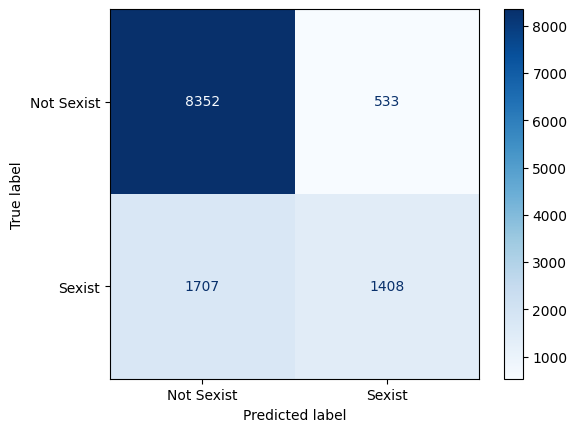

In [18]:
disp = ConfusionMatrixDisplay(confusion_matrix=scores.confusion_matrix(), display_labels=["Not Sexist", "Sexist"]).plot(cmap="Blues")

We improve with the hyperoptimization from a fscore of 51.5% for the default configuration to a fscore of 55.7% for the best found parameter configuration. Both the test set and the validation yield very similar performance metrics, indictating that no overfit by the optimization process is present.

# Report model to MLflow
The optimized model is uploaded to our [self hosted mlflow](https://mlflow.mahluke.page) for documentation purposes.

In [19]:
with mlflow.start_run(
        experiment_id=get_experiment().experiment_id, 
        run_name="xgboost hyperopt"
        ):
    mlflow.log_params(clf.get_xgb_params())
    mlflow.log_metrics(scores.asdict())
    mlflow.set_tag("model", "XGBoost")
    signature = infer_signature(X_train, clf.predict(X_train))
    mlflow.log_table({"id": test["id"], "prediction": y_pred}, "predictions.json")
    mlflow.log_figure(disp.figure_, "confusion_matrix.png")

    # log the model
    model_info: ModelInfo = mlflow.xgboost.log_model(
        clf,
        "",
        signature=signature,
        registered_model_name="xgboost",
    )
client().set_registered_model_alias("xgboost", "current", model_info.registered_model_version)

/home/lukas/Programming/uni/nlp-ie-label-legends/.venv/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [00:48:07] WARNING: /workspace/src/c_api/c_api.cc:1374: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  warnings.warn(smsg, UserWarning)


2024/12/15 00:48:09 WARNING mlflow.utils.environment: Failed to resolve installed pip version. ``pip`` will be added to conda.yaml environment spec without a version specifier.


Registered model 'xgboost' already exists. Creating a new version of this model...


2024/12/15 00:48:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: xgboost, version 4


Created version '4' of model 'xgboost'.


🏃 View run xgboost hyperopt at: https://mlflow.mahluke.page/#/experiments/769295261228132607/runs/629244bc27484e8baaa34e8ffb5dea18
🧪 View experiment at: https://mlflow.mahluke.page/#/experiments/769295261228132607


# Load predictions from MLflow
The following cells show how we can interact with mlflow to download the predictions and load them into polars.

In [17]:
get_current("xgboost")

<ModelVersion: aliases=['current'], creation_timestamp=1734211663455, current_stage='None', description='', last_updated_timestamp=1734211663455, name='xgboost', run_id='0bf1017dcd3f4639825f044f082aa851', run_link='', source='mlflow-artifacts:/769295261228132607/0bf1017dcd3f4639825f044f082aa851/artifacts', status='READY', status_message='', tags={}, user_id='', version='2'>

In [21]:
download_conf_mat("xgboost")

In [18]:
# Download the most recent predictions of the model
download_predictions("xgboost")


In [19]:
load_predictions("xgboost").head()

id,prediction
i64,i64
100,0
10005,1
10006,1
10007,1
10008,0
